STOCKS PREDICTION USING ARIMA MODEL

Note: you may need to restart the kernel to use updated packages.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6932 entries, 0 to 6931
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6932 non-null   object 
 1   Open    6932 non-null   float64
 2   High    6932 non-null   float64
 3   Low     6932 non-null   float64
 4   Close   6932 non-null   float64
 5   Volume  6932 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 325.1+ KB


<Axes: >

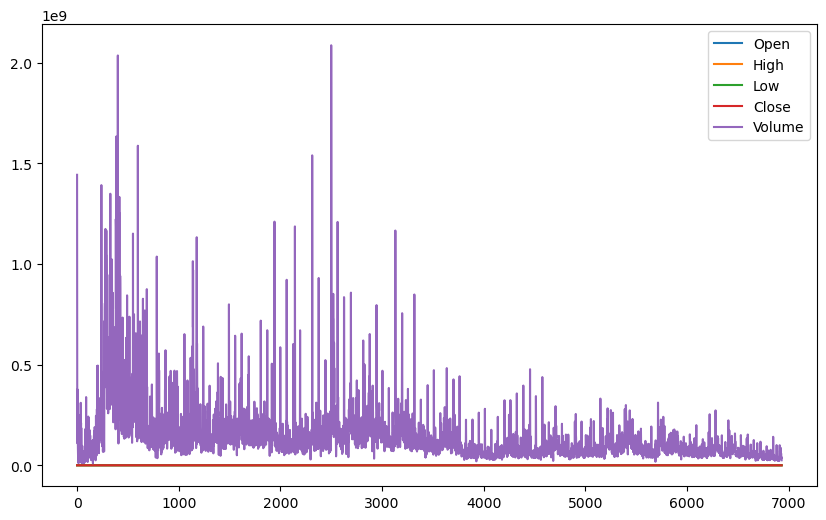

In [843]:
%pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
import math

df = pd.read_csv('AMZN.csv')
df.info()
df.plot()

Stocks data:

In [845]:
df

,Date,Open,High,Low,Close,Volume
0,1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000
1,1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000
2,1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000
3,1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000
4,1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000
...,...,...,...,...,...,...
6927,2024-11-22 00:00:00-05:00,198.250000,199.259995,196.750000,197.119995,31530800
6928,2024-11-25 00:00:00-05:00,199.279999,201.949997,199.000000,201.449997,40685700
6929,2024-11-26 00:00:00-05:00,201.899994,208.000000,201.789993,207.860001,41673700
6930,2024-11-27 00:00:00-05:00,206.979996,207.639999,205.050003,205.740005,28061600


Display summary statistics

In [847]:
df.describe()

,Open,High,Low,Close,Volume
count,6932.000000,6932.000000,6932.000000,6932.000000,6.932000e+03
mean,39.213442,39.672243,38.714291,39.205112,1.368513e+08
std,55.939448,56.566019,55.247921,55.916740,1.378218e+08
min,0.070313,0.072396,0.065625,0.069792,9.744000e+06
25%,2.089000,2.137500,2.051375,2.094750,6.377350e+07
50%,8.910500,8.992500,8.801750,8.902250,1.011230e+08
75%,62.880501,63.184500,62.271751,62.995874,1.558935e+08
max,214.160004,215.899994,210.880005,214.100006,2.086584e+09


In [848]:
df['Date'] = pd.to_datetime(df['Date'], utc = True)

Plot the closing price from 1997 - 2024

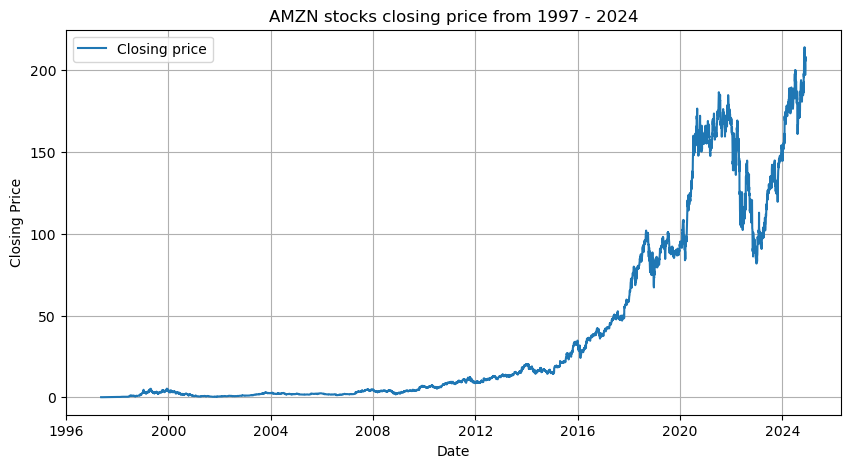

In [850]:
plt.figure(figsize = (10,5))
plt.plot(df['Date'], df['Close'], label = 'Closing price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN stocks closing price from 1997 - 2024')
plt.legend()
plt.grid(True)
plt.show()

Plot the volume of the stocks data from 1997 - 2024

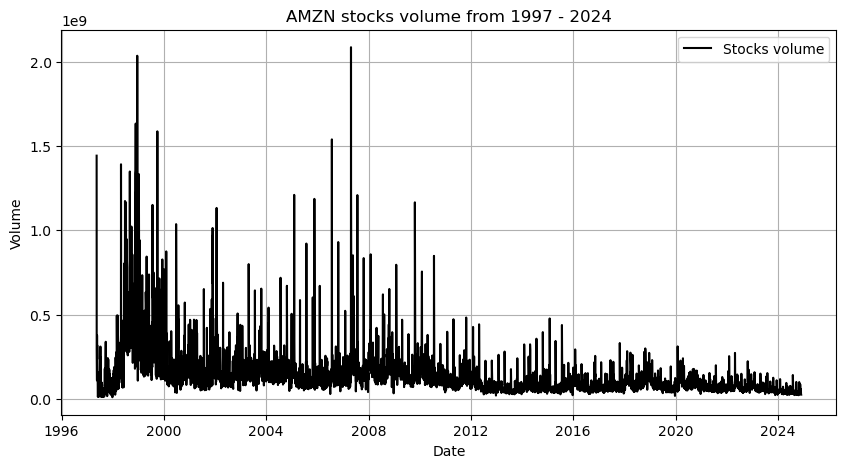

In [852]:
plt.figure(figsize = (10,5))
plt.plot(df['Date'], df['Volume'], label = 'Stocks volume', color = 'black')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('AMZN stocks volume from 1997 - 2024')
plt.legend()
plt.grid(True)
plt.show()

Probability distribution of AMZN

<Axes: ylabel='Density'>

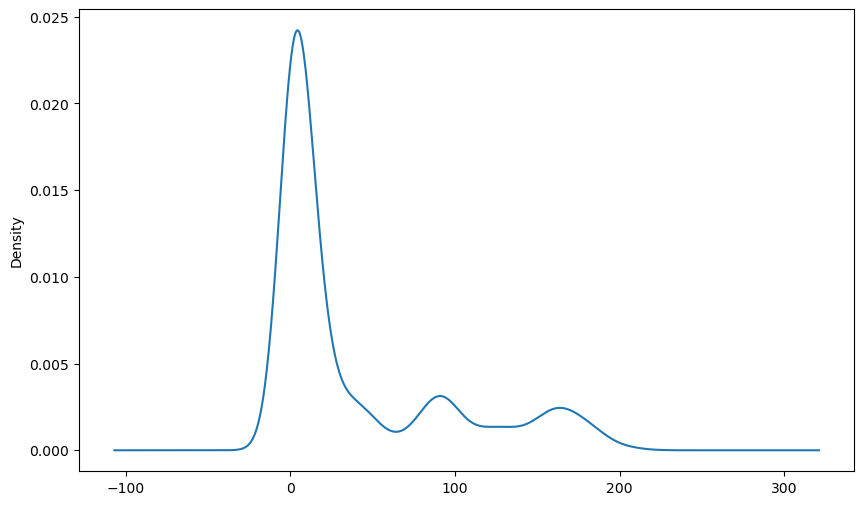

In [854]:
df['Close'].plot(kind = 'kde')

Plot the moving average of AMZN from 1997 - 2024

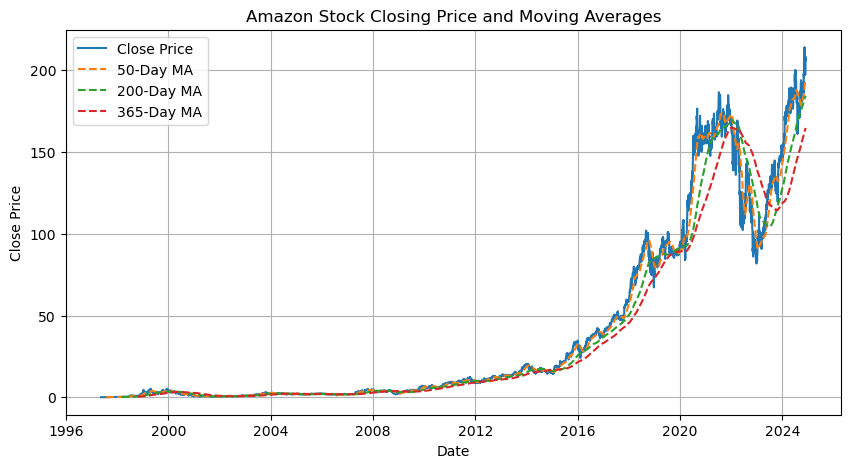

In [856]:
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()
df['365_MA'] = df['Close'].rolling(window=365).mean()

plt.figure(figsize = (10, 5))
plt.plot(df['Date'], df['Close'], label = 'Close Price')
plt.plot(df['Date'], df['50_MA'], label = '50-Day MA', linestyle = '--')
plt.plot(df['Date'], df['200_MA'], label = '200-Day MA', linestyle = '--')
plt.plot(df['Date'], df['365_MA'], label = '365-Day MA', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Amazon Stock Closing Price and Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

Check for stationarity of time series (ADF-test):

    -Null Hypothesis: The series has a unit root (value of a =1)
    -Alternate Hypothesis: The series has no unit root.

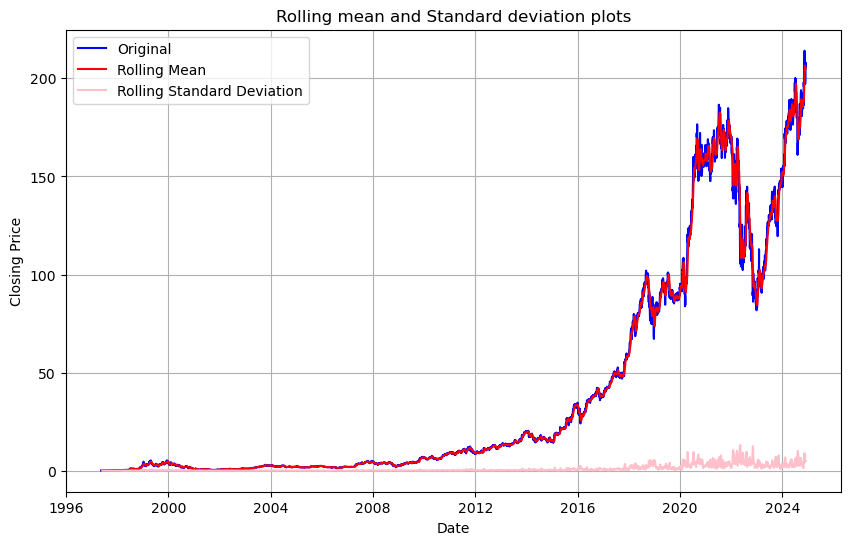

result of ADF test:
Test Statistics                  1.612481
P-value                          0.997895
No. of lags used                34.000000
Number of Observation used    6897.000000
critical value (1%)             -3.431298
critical value (5%)             -2.861959
critical value (10%)            -2.566993
dtype: float64


In [858]:
def test_stationary(time_series):
    
    #determine rolling stats:
    rolmean = time_series.rolling(12).mean()
    rolstd = time_series.rolling(12).std()
    
    #Plot rolling stats:
    plt.plot(df['Date'], time_series, label = 'Original', color = 'blue')
    plt.plot(df['Date'], rolmean, label = 'Rolling Mean', color = 'red')
    plt.plot(df['Date'], rolstd, label = 'Rolling Standard Deviation', color = 'pink')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.title('Rolling mean and Standard deviation plots')
    plt.show(block = False)

    print('result of ADF test:')
    adft = adfuller(time_series, autolag = 'AIC')

    #output:
    output = pd.Series(adft[0:4], index = ['Test Statistics', 'P-value','No. of lags used','Number of Observation used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)
    
test_stationary(df['Close'])

The increasing in mean and std. deviation, with the high value of P-value indicates that our series is non-stationary

Check for null values:

In [861]:
df.isnull().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
50_MA      49
200_MA    199
365_MA    364
dtype: int64

Isolated the time series from Seasonality and Trend:

<Figure size 1000x600 with 0 Axes>

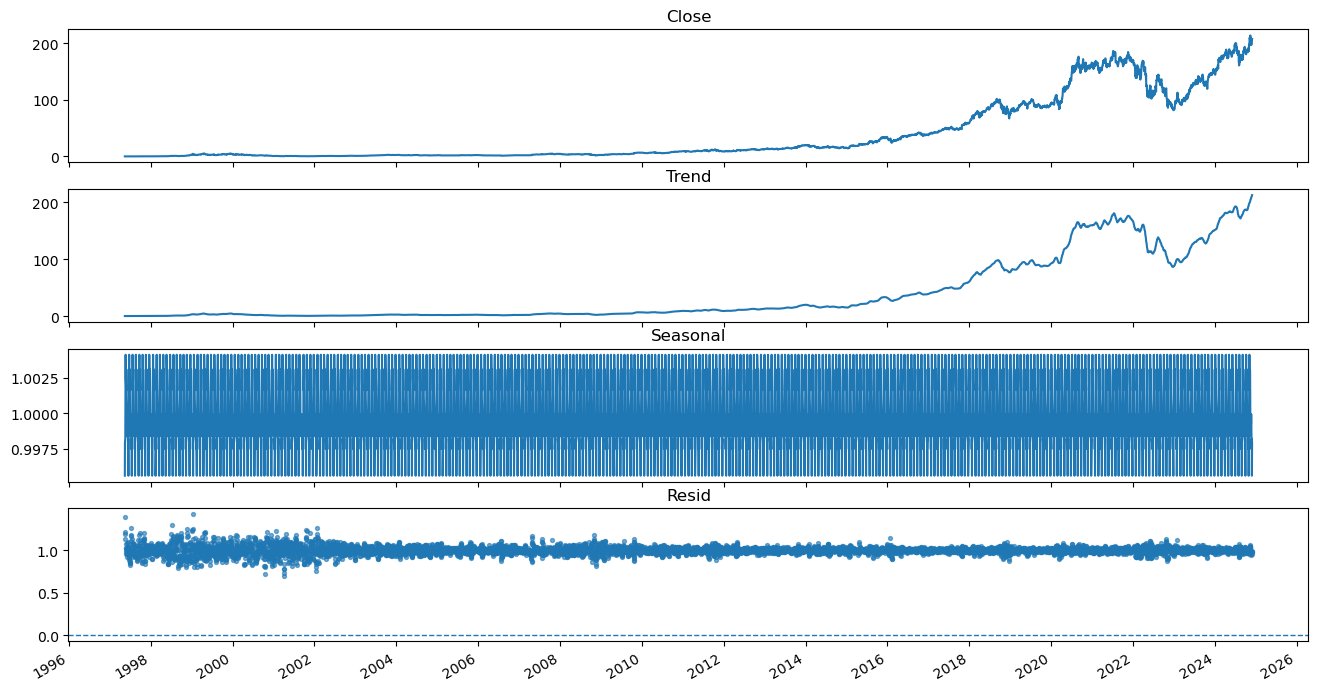

In [893]:
fig = plt.figure()
# fig = result.plot()

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], utc = True)
    df = df.sort_values('Date').set_index('Date')
else:
     df.index = pd.to_datetime(df.index, utc=True)
     df = df.sort_index()

s = df['Close'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
s = s[s > 0]                 # multiplicative requires > 0

period = 21

r = res.resid.dropna()                   # residuals have NaNs at the ends


result = seasonal_decompose(s, model = 'multiplicative', period = 30)

res = seasonal_decompose(s, model='multiplicative', period=period, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(16, 9), sharex=True)
axes[0].plot(s.index, res.observed);  axes[0].set_title('Close')
axes[1].plot(s.index, res.trend);     axes[1].set_title('Trend')
axes[2].plot(s.index, res.seasonal);  axes[2].set_title('Seasonal')


axes[3].scatter(r.index, r, s=8, alpha=0.6)  # <-- scatter instead of line
axes[3].axhline(0, ls='--', lw=1)            # baseline
axes[3].set_title('Resid')

# Nice date ticks
axes[-1].xaxis.set_major_locator(mdates.YearLocator(base=2))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
# plt.tight_layout()
plt.show()
# # 2) Give it a frequency (business days here)

# for ax in fig.axes:
#     ax.set_xlim(start, end)                       # start at first date
#     ax.xaxis.set_major_locator(mdates.YearLocator(base=10))     # tick every 2 years (adjust as needed)
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# fig.autofmt_xdate()
# fig.set_size_inches(16,9)
# plt.show()

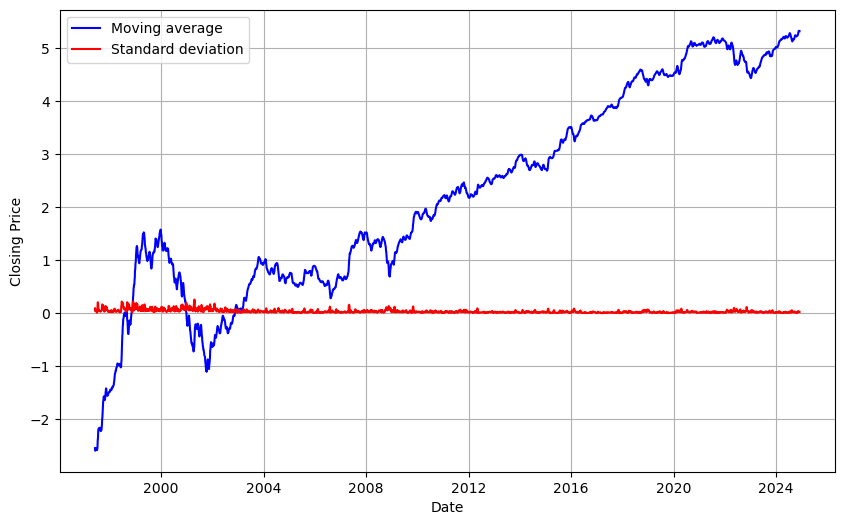

In [864]:
#If not stationary, then eliminate Trend and calculate the rolling average again:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
mov_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df.index, mov_avg, label = 'Moving average', color = 'blue')
plt.plot(df.index, std_dev, label = 'Standard deviation', color = 'red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show(block = False)

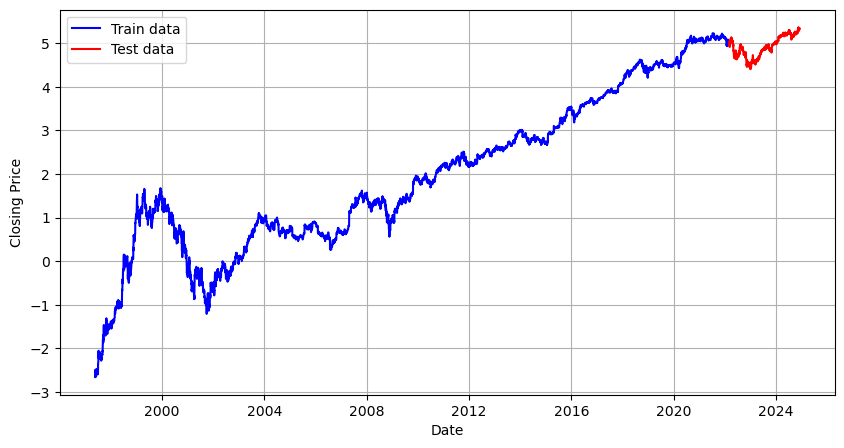

In [865]:
#Create train and test datas for training ARIMA:
train_data = df_log[3:int(len(df_log)*0.9)]
test_data = df_log[int(len(df_log)*0.9):]
plt.figure(figsize = (10,5))
plt.plot(train_data, label = 'Train data', color = 'blue')
plt.plot(test_data, label = 'Test data', color = 'red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show(block = False)

Time Series Prediction using Autofit - ARIMA:


Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 64.411 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6235
Model:               SARIMAX(2, 1, 0)   Log Likelihood               11913.702
Date:                Tue, 04 Nov 2025   AIC                         -23819.404
Time:                        18:02:14   BIC                         -23792.453
Sample:                             0   HQIC                        -23810.063
                               - 6235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      2.715      0.007       0.000       0.002
ar.L1          0.0032      0.007      0.430      0.66

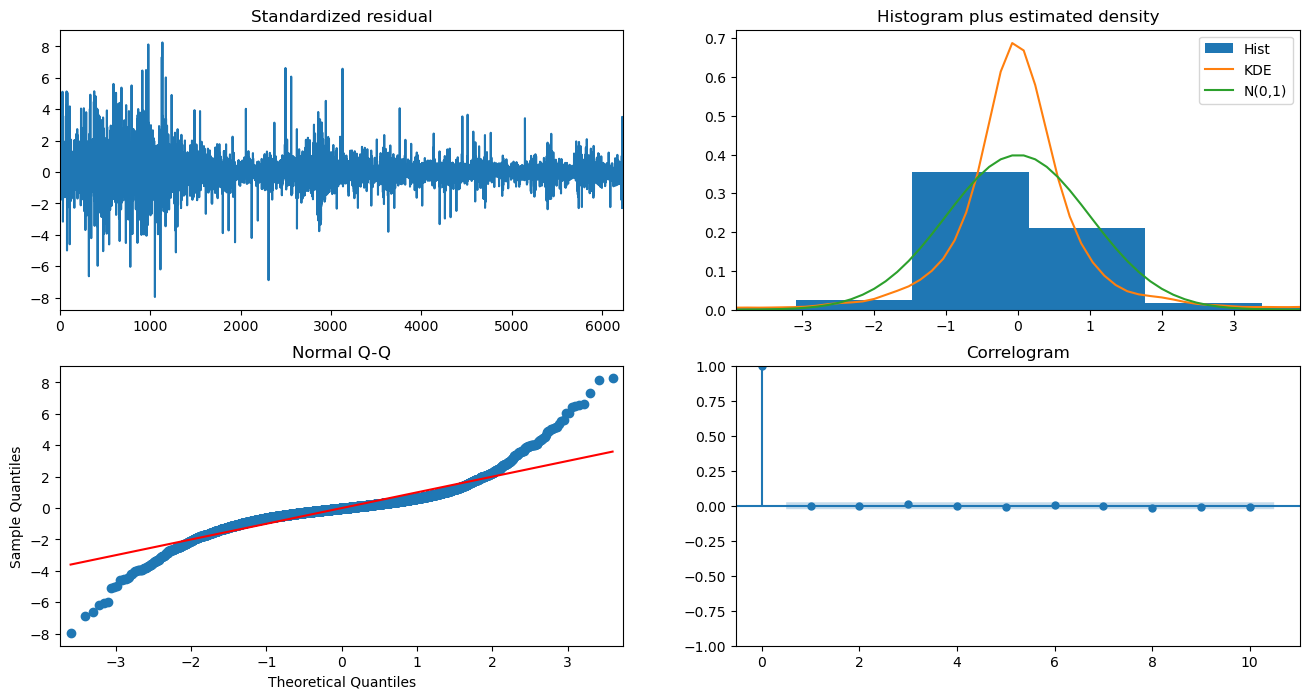

In [867]:
autoARIMA_model = auto_arima(
    train_data,
    start_p=0, start_q=0,
    max_p=4, max_q=4,
    d=None, test='adf',
    seasonal=False, m=1,
    stepwise=False,          # exhaustive grid search
    max_order=None,          # remove p+q cap (or set >= 8)
    error_action='warn',     # see why models are skipped
    suppress_warnings=False,
    trace=True,
    n_jobs=-1
)
print(autoARIMA_model.summary())



autoARIMA_model.plot_diagnostics(figsize = (16,8))

plt.show()

The residual plot show stationary in the mean 0 and have a uniform variance.

The density plot show normal distribution around the mean 0.

The QQ-test shows the distribution is skewwed since the dots lies briefly on the redline with some significant deviations in the top right and bottom 
left of the plot.

The ACF plot shows that the residuals errors will not be auto-correlated. Which implies that the patterns of some residual models were not showed in the plot. We have to double check on some other predictors to have the most appropriate fit.

Overal this is not a bad fit. Let's predict the stocks price:

In [869]:
m = autoARIMA_model  # just a shorter name
p, d, q           = m.order                # (p,d,q)


#Build ARIMA model:
model = ARIMA(train_data, order = (p,d,q))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6235
Model:                 ARIMA(2, 1, 0)   Log Likelihood               11909.961
Date:                Tue, 04 Nov 2025   AIC                         -23813.921
Time:                        18:02:19   BIC                         -23793.708
Sample:                             0   HQIC                        -23806.916
                               - 6235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0044      0.007      0.592      0.554      -0.010       0.019
ar.L2         -0.0289      0.008     -3.637      0.000      -0.044      -0.013
sigma2         0.0013   9.64e-06    132.991      0.0

In [870]:
#forecast
# fc = fitted.forecast(321, alpha = 0.05) #confidence interval of 95%
se = fitted.forecast(321, alpha = 0.05)
# conf = fitted.forecast(8, alpha = 0.05)

fc, conf = autoARIMA_model.predict(n_periods=len(test_data), return_conf_int=True)

# normalize to a 2-D numpy array with shape (n, 2)
if isinstance(conf, pd.DataFrame):
    conf = conf.values          # DataFrame -> ndarray
else:
    conf = np.asarray(conf)     # Series/list -> ndarray

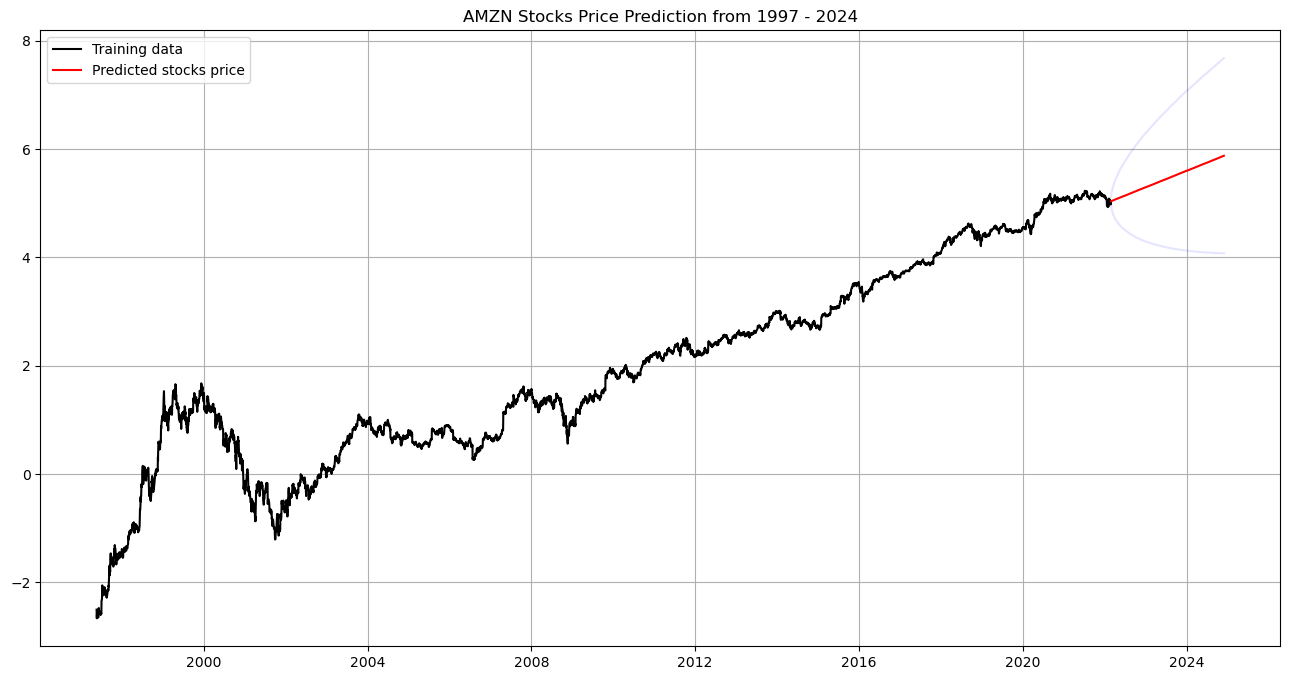

In [871]:
# Make as pandas series
# fc_series = pd.Series(fc, index = test_data.index)
fc_series    = pd.Series(np.asarray(fc).ravel(), index=test_data.index)
lower_series = pd.Series(np.asarray(conf[:,0]), index=test_data.index)
upper_series = pd.Series(np.asarray(conf[:,1]), index=test_data.index)

#Plot the prediction:
plt.figure(figsize = (16,8))
plt.plot(train_data, label = 'Training data', color = 'black')
plt.plot(fc_series, label = 'Predicted stocks price', color = 'red')
plt.plot(lower_series.index, lower_series, upper_series, color = 'blue', alpha = 0.10)
plt.title('AMZN Stocks Price Prediction from 1997 - 2024')
plt.legend()
plt.grid(True)



plt.show()

In [872]:
#Report based on performance:
mse =  mean_squared_error(test_data, fc)
mae = mean_absolute_error(test_data, fc)
print(f'MAE: {str(mae)}')
print(f'MSE: {str(mse)}')
rmse = math.sqrt(mean_squared_error(test_data, fc))
print(f'RMSE: {str(rmse)}')
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print(f'MAPE: {str(mape)}')

MAE: 0.5358168535735128
MSE: 0.31971409469031553
RMSE: 0.5654326614994181
MAPE: nan
